### Financial Index Prediction
This notebook seeks to predict the direction of a financial index from day k to day k+1 given financial news headlines from day k. A range of different combinations between statistical and NLP-models are used. 

In [10]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.utils import parallel_backend
from pathlib import Path
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Embedding, Lambda, LSTM, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize

#### Load financial news data and financial index data

In [11]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-10-20' : '2013-11-20']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [12]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates()

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
valid_dates.append(fin_data.index[-1]) # Add the last index in fin_data and remove after creating targets
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for date in tqdm(valid_dates[1:]): # The first date is fin_data.iloc[0] 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.loc[date]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.loc[date]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.loc[date]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.loc[date]
valid_dates.remove(fin_data.index[-1]) # Remove since this date is not present in news data


100%|█████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:08<00:00, 223.66it/s]


In [13]:
def format_word(word): 
    """ A method for formatting words to be more similar to those in the 
    pre-trained glove embeddings. For example, won't -> will not, removing 's etc. 
    """
    if word == "n't":
        return "not"
    if word == "'s": 
        return ""
    if word == "wo":
        return "will"
    if len(word) > 1 and word[0] == "'":
        return word[1:]
    return word

In [14]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for date in valid_dates: 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        words = word_tokenize(text.lower())
        for j,word in enumerate(words): 
            if j < len(words) - 1:
                temp_texts += format_word(word) + " "
            else:
                temp_texts += format_word(word) + ". "
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))
n = len(targets)

Length of texts: 1846
Length of targets: 1846


#### Vectorize the news titles using GloVe
The headlines are tokenized, and a vector of length 300 is constructed by the elementwise average of the GloVe-embeddings for one review. This is used as input to the models where the embeddings are not jointly trained with the model. For the bidirectional LSTM however, the news titles are tokenized and fed into an embedding layer where the initial embeddings are given by the pre-trained GloVe embeddings. 

In [15]:
# Tokenize the text data 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [16]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300)) # Need one extra row since '0' is not an index
glove_path = ONEDRIVE_PATH / "Embeddings\GloVe\glove.42B.300d\glove.42B.300d.txt"
found_words = []
f = open(glove_path,'r', encoding='UTF-8')
for line in f:
    splitLine = line.split()
    word = splitLine[0]
    if word in tokenizer.word_index.keys():
        found_words.append(word)
        embedding_matrix[tokenizer.word_index[word]] = np.array([float(val) for val in splitLine[1:]])
print("Done.",len(found_words),"words loaded,",len(tokenizer.word_index) - len(found_words),"not found.")

Done. 22107 words loaded, 308 not found.


In [18]:
x = np.zeros((len(texts), 300))
title_lengths = np.zeros(len(texts))  # Record the length of every concatenated title to determine suitable maxlength for sequential data. 
for i,title in tqdm(enumerate(texts)):
    tokenized_title = tokenizer.texts_to_sequences(word_tokenize(title))
    temp_array = np.zeros((300))
    n_words = 0
    title_lengths[i] = len(tokenized_title)
    for word in tokenized_title:     
        if len(word) == 1:
            temp_array += embedding_matrix[word[0]]
            n_words += 1
    x[i] = temp_array / n_words

1846it [00:28, 63.95it/s]


#### Vectorize sequences using GloVe
We'll also try a recurrent approach with sequences as input. Instead of taking the average of the GloVe-embedding in one review, a sequence of word indices is fed into an embedding layer where the embeddings are initialized as pretrained GloVe-embeddings. However, using all of the words in the vocabulary gives a too slow model so we have to re-tokenize with a restricted vocabulary size. We'll also restrict the maximum word length from one review to cover the majority of the training samples without being too inefficient. 

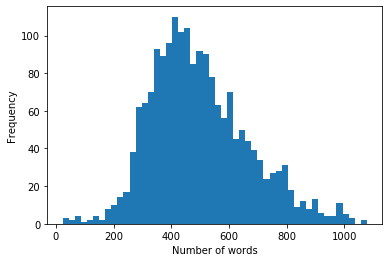

In [19]:
plt.hist(title_lengths,50)
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show() 

A maximum sentence length of 800 seems reasonable to cover the majority. Furthermore, we restrict the size of the vocabulary to make the task computationally feasible. 

In [20]:
# Tokenize the text data 
maxlen = 800
# Restrict size of the vocabulary
vocab_size = 20000
restricted_tokenizer = Tokenizer(num_words=vocab_size,lower=True)
restricted_tokenizer.fit_on_texts(texts)
x_restr = restricted_tokenizer.texts_to_sequences(texts)
# Pad the data with zeroes so all samples are of equal length
x_padded = pad_sequences(x_restr,maxlen=maxlen)

# Create a new embedding matrix for the restricted vocabulary ('embedding_matrix' includes the full vocabulary)
trainable_embeddings = np.zeros((vocab_size + 1, 300))    
for i,word in enumerate(list(restricted_tokenizer.word_index.keys())[:vocab_size]):
    trainable_embeddings[i] = embedding_matrix[tokenizer.word_index[word]]


#### Partition into training and test set
The data is somewhat imbalanced to a various degree for the different time series. The partition is made so that the distribution of labels is respected in both the training and test set. 

In [21]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6885157096424702
Neg labels: 1271 Pos labels: 575
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.594257854821235
Neg labels: 1097 Pos labels: 749
 -----     S&P     -----
Ratio neg labels S&P: 0.4647887323943662
Neg labels: 858 Pos labels: 988


In [25]:
n_train = 1200


np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)


x_train_1yr = x[train_indices_1yr]
x_train_seq_1yr = x_padded[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
x_test_seq_1yr = x_padded[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values


x_train_3yr = x[train_indices_3yr]
x_train_seq_3yr = x_padded[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
x_test_seq_3yr = x_padded[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values


x_train_sp = x[train_indices_sp]
x_train_seq_sp = x_padded[train_indices_sp]
x_test_sp = x[test_indices_sp]
x_test_seq_sp = x_padded[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values

# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))

print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1200, 300) , (1200,)
Train data label ratio (0 / 1): 826 / 374
Test data shape (x,y): (646, 300) , (646,)
Test data label ratio (0 / 1): 445 / 201
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1200, 300) , (1200,)
Train data label ratio (0 / 1): 713 / 487
Test data shape (x,y): (646, 300) , (646,)
Test data label ratio (0 / 1): 384 / 262
 -----     S&P     -----
Train data shape (x,y): (1200, 300) , (1200,)
Train data label ratio (0 / 1): 558 / 642
Test data shape (x,y): (646, 300) , (646,)
Test data label ratio (0 / 1): 300 / 346


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [26]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs GloVe/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs GloVe/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs GloVe/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

## Random Classifier
Just for real simple comparison. 
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.70      0.72      0.71       445
         1.0       0.33      0.31      0.32       201

    accuracy                           0.59       646
   macro avg       0.52      0.51      0.51       646
weighted avg       0.58      0.59      0.59       646

Test accuracy: 0.56656346749226


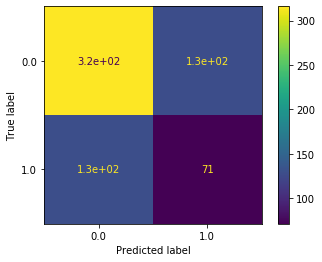

In [28]:
# Dummy Classifier
dummy_clf_1yr = DummyClassifier().fit(x_train_1yr, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.57      0.60      0.58       384
         1.0       0.36      0.34      0.35       262

    accuracy                           0.49       646
   macro avg       0.47      0.47      0.47       646
weighted avg       0.48      0.49      0.49       646

Test accuracy: 0.5154798761609907


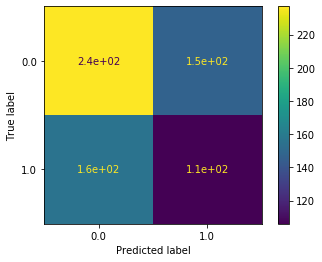

In [29]:
# Dummy Classifier
dummy_clf_3yr = DummyClassifier().fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.53      0.51      0.52       300
         1.0       0.59      0.60      0.59       346

    accuracy                           0.56       646
   macro avg       0.56      0.56      0.56       646
weighted avg       0.56      0.56      0.56       646

Test accuracy: 0.544891640866873


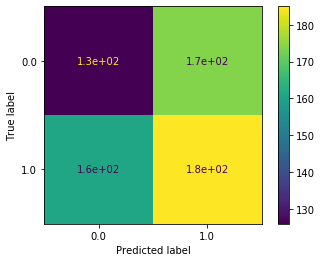

In [30]:
# Dummy Classifier
dummy_clf_sp = DummyClassifier().fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

### Logistic Regression with GloVe
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       1.00      0.00      0.01       201

    accuracy                           0.69       646
   macro avg       0.84      0.50      0.41       646
weighted avg       0.79      0.69      0.57       646

Test accuracy: 0.6904024767801857


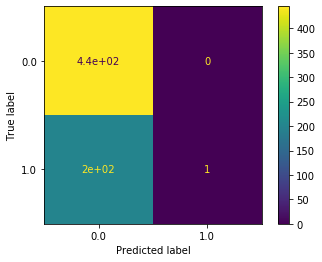

In [31]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.59      0.95      0.73       384
         1.0       0.39      0.05      0.09       262

    accuracy                           0.58       646
   macro avg       0.49      0.50      0.41       646
weighted avg       0.51      0.58      0.47       646

Test accuracy: 0.5835913312693498


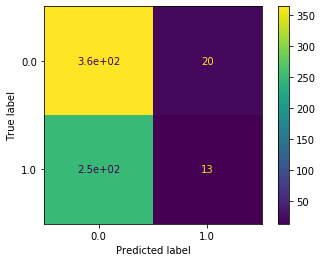

In [34]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0,max_iter=10000).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.49      0.25      0.33       300
         1.0       0.54      0.78      0.64       346

    accuracy                           0.53       646
   macro avg       0.52      0.51      0.49       646
weighted avg       0.52      0.53      0.50       646

Test accuracy: 0.5325077399380805


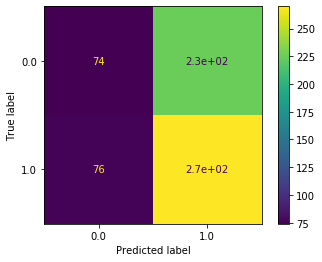

In [35]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

### Support Vector Machine with GloVe
#### 1 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.6888544891640866


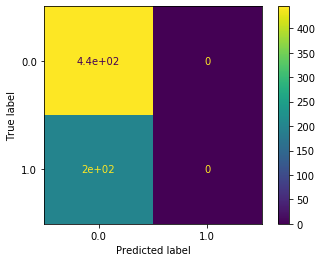

In [38]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.59      1.00      0.75       384
         1.0       0.00      0.00      0.00       262

    accuracy                           0.59       646
   macro avg       0.30      0.50      0.37       646
weighted avg       0.35      0.59      0.44       646

Test accuracy: 0.5944272445820433


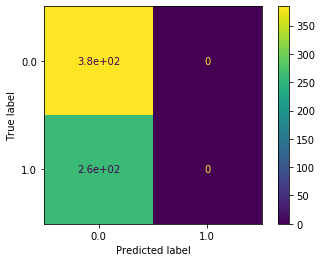

In [39]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       300
         1.0       0.54      1.00      0.70       346

    accuracy                           0.54       646
   macro avg       0.27      0.50      0.35       646
weighted avg       0.29      0.54      0.37       646

Test accuracy: 0.5356037151702786


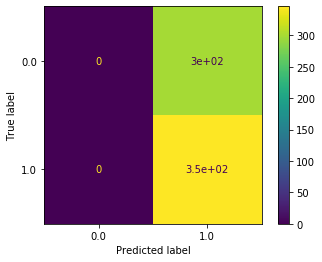

In [40]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random forest with GloVe
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.0min finished


Best: 0.685833 using {'max_depth': 100, 'n_estimators': 750}
0.684167 (0.014167) with: {'max_depth': None, 'n_estimators': 250}
0.681667 (0.012247) with: {'max_depth': None, 'n_estimators': 500}
0.684167 (0.012047) with: {'max_depth': None, 'n_estimators': 750}
0.683333 (0.012910) with: {'max_depth': None, 'n_estimators': 1000}
0.677500 (0.019021) with: {'max_depth': 50, 'n_estimators': 250}
0.680833 (0.013969) with: {'max_depth': 50, 'n_estimators': 500}
0.684167 (0.016436) with: {'max_depth': 50, 'n_estimators': 750}
0.684167 (0.014167) with: {'max_depth': 50, 'n_estimators': 1000}
0.680833 (0.016266) with: {'max_depth': 100, 'n_estimators': 250}
0.682500 (0.011456) with: {'max_depth': 100, 'n_estimators': 500}
0.685833 (0.010574) with: {'max_depth': 100, 'n_estimators': 750}
0.684167 (0.012047) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.69      0.99      0.81       445
         1.0       0.33      0.01  

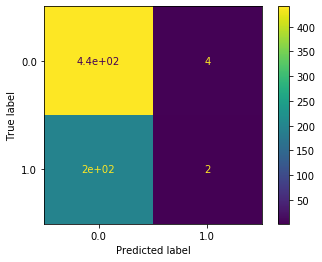

In [42]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='accuracy',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

In [ ]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='accuracy',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### S&P

In [ ]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='accuracy',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Networks

In [43]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

In [ ]:
n_tests = 50
# Define possible parameters 
possible_params = dict(batch_size = [8, 16, 32],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)

### Feed forward, pre-trained embeddings
#### 1 year rate 

In [ ]:
historylist_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_1yr.append(history)
max_acc_1yr = -1
max_idx_1yr = -1
for i,hist in enumerate(historylist_1yr):
    if max(hist.history['val_acc']) > max_acc_1yr: 
        max_acc_1yr = max(hist.history['val_acc'])
        max_idx_1yr = i
    
print("Best val acc:",max_acc_1yr)
print("For config: ",test_params[max_idx_1yr])


Fitting 3 folds for each of 864 candidates, totalling 2592 fits
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=rmsprop, score=0.660, total=   3.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=rmsprop, score=0.683, total=   3.0s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=rmsprop, score=0.702, total=   3.1s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=adam 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.6s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=adam, score=0.678, total=   3.2s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=adam 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.8s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=adam, score=0.647, total=   3.0s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=adam 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.8s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=50, optimizer=adam, score=0.700, total=   2.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   18.4s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=rmsprop, score=0.673, total=   2.8s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.3s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=rmsprop, score=0.670, total=   3.2s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=rmsprop 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   24.4s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=rmsprop, score=0.705, total=   3.5s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=adam 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.9s remaining:    0.0s


[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=adam, score=0.670, total=   3.5s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=adam, score=0.683, total=   3.3s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=100, optimizer=adam, score=0.705, total=   6.7s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=250, optimizer=rmsprop, score=0.678, total=   4.3s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=50, nodes2=250, optimizer=rmsprop 
[CV]  batch_siz

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.680, total=   9.0s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=rmsprop, score=0.618, total=   8.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=adam, score=0.675, total=   7.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=adam, score=0.618, total=   7.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=100, nodes2=500, optimizer=adam 
[CV]  b

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=50, optimizer=adam, score=0.505, total=   8.8s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=50, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=50, optimizer=adam, score=0.697, total=   9.1s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.678, total=  10.4s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.680, total=  11.0s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.001, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=rmsprop, score=0.685, total=  17.7s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=rmsprop, score=0.702, total=  19.3s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=adam, score=0.678, total=  19.3s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=adam, score=0.685, total=  18.8s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=50, nodes2=250, optimizer=adam 
[CV]  b

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=100, nodes2=500, optimizer=adam, score=0.685, total=  32.4s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=100, nodes2=500, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=100, nodes2=500, optimizer=adam, score=0.702, total=  33.5s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=250, nodes2=50, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=250, nodes2=50, optimizer=rmsprop, score=0.678, total=  31.7s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=250, nodes2=50, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=250, nodes2=50, optimizer=rmsprop, score=0.685, total=  40.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=250, nodes2=50, optimizer=rmsprop

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.685, total=  46.1s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=rmsprop, score=0.702, total=  51.4s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=adam, score=0.675, total=  44.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=adam, score=0.685, total=  55.6s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=0.0001, nodes1=500, nodes2=100, optimizer=adam 

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=250, optimizer=adam, score=0.685, total= 1.0min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=250, optimizer=adam, score=0.702, total=  53.8s
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=500, optimizer=rmsprop, score=0.678, total= 1.1min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=500, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=500, optimizer=rmsprop, score=0.685, total= 1.1min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=50, nodes2=500, optimizer=rmsprop 
[CV]  bat

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=rmsprop, score=0.702, total= 1.3min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=adam, score=0.678, total= 1.1min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=adam, score=0.685, total= 1.6min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=50, optimizer=adam, score=0.702, total= 1.3min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=250, nodes2=100, optimizer=rmsprop 
[CV]  batch_size=

[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.678, total= 1.7min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.685, total= 1.9min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=rmsprop 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=rmsprop, score=0.702, total= 3.0min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=adam 
[CV]  batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=adam, score=0.678, total= 2.3min
[CV] batch_size=8, dropout_rate=0.1, epochs=10, learning_rate=1e-05, nodes1=500, nodes2=250, optimizer=adam 
[

In [ ]:
bs = test_params[max_idx_1yr].pop('batch_size')
model_ff_1yr = create_model(**test_params[max_idx_1yr])
test_params[max_idx_1yr].update({'batch_size': bs})

history_1yr = model_ff_1yr.fit(x_train_1yr, y_train_1yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_1yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_1yr]['batch_size'],
                                                          test_params[max_idx_1yr]['nodes1'],
                                                          test_params[max_idx_1yr]['nodes2'],
                                                          test_params[max_idx_1yr]['dropout_rate'],
                                                          test_params[max_idx_1yr]['learning_rate'],
                                                          test_params[max_idx_1yr]['optimizer'])
plot_results_nn(history_1yr,model_ff_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_1yr)

#### 3 year rate

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop [CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 

[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.524, total=   5.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.514, total=   5.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.542, total=   5.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.7s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.523, total=   6.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.483, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.509, total=   6.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.517, total=   6.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.8s



[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.476, total=   8.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.526, total=   9.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.477, total=   9.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.474, total=   9.3s
[CV] batch_size=8, depth=1, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_10719/acc/Cast_1'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.7s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.526, total=   5.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.485, total=   6.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.502, total=   5.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.483, total=   5.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5368/dense_3_loss/num_elements/Cast'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.506, total=  19.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.4s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.500, total=   6.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.483, total=   5.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.482, total=   6.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.474, total=   6.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   32.9s



[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.468, total=   5.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.535, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.476, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.495, total=   6.0s
[CV] batch_size=8, depth=1, d

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   39.4s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.453, total=   5.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5391/dense_6_loss/Mean'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_10785/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.471, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.494, total=   6.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epo

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.8s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.488, total=   5.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.498, total=   6.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.471, total=   6.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, 

[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   57.5s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.471, total=   6.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.527, total=   7.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.529, total=   7.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.550, total=  12.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.523, total=   7.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.500, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.529, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.503, total=   7.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, drop

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5443/dense_11_loss/mul'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.495, total=   8.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.486, total=   8.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.470, total=   8.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.508, total=   8.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.477, total=   8.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.500, total=   8.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.505, total=   8.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.479, total=   8.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.471, total=   7.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.532, total=   8.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=   8.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.547, total=  10.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.514, total=  10.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.502, total=  10.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_10987/acc/Identity'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5494/dense_19_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   0.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.518, total=  10.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5498/dense_21_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=nan, total=   0.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.492, total=  15.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.529, total=  13.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.517, total=  14.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5504/dense_20_loss/weighted_loss/broadcast_weights/ones_like'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.502, total=  13.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.509, total=  10.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.523, total=  10.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.521, total=  10.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.8min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.474, total=  10.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.518, total=  10.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.517, total=  10.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.494, total=  27.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, 

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.486, total=  10.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.500, total=  10.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.489, total=  10.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.524, total=  10.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  3.7min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.529, total=  10.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.508, total=  10.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.491, total=  10.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.471, total=  10.4s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  4.1min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.426, total=   9.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.530, total=   9.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.529, total=   5.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.477, total=   5.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_r

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  4.4min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.536, total=   6.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.474, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.465, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.509, total=   6.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  4.7min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.459, total=   6.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.503, total=   6.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.532, total=   6.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.532, total=   6.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5632/dense_39_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.529, total=   6.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.471, total=   6.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.506, total=   8.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  5.1min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.500, total=  12.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.547, total=  12.0s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.547, total=  11.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.505, total=  11.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  5.6min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.465, total=   8.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.477, total=   8.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.494, total=   8.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.514, total=   8.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5684/dense_40_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.468, total=   8.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.529, total=   8.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.503, total=   8.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.0min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.468, total=   8.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.529, total=   9.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.497, total=   8.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.468, total=   8.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rat

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5717/dense_48_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.518, total=  10.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.505, total=  10.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.541, total=  15.4s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  6.7min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.518, total=  13.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.514, total=  13.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.497, total=  13.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.495, total=  13.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  7.3min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.509, total=  12.4s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.477, total=  11.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.474, total=  10.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.471, total=  11.0s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_11534/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   0.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.468, total=  12.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.529, total=  11.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.449, total=  11.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rat

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.0min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.518, total=   9.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.483, total=   9.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.529, total=   9.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.544, total=   9.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5784/dense_55_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.515, total=   8.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.509, total=   7.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.505, total=   8.7s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, ep

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_58_23/MatMul'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_11600/acc/Cast_3'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.471, total=   9.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.506, total=   9.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.523, total=   8.7s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5808/dense_60_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.530, total=  10.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.462, total=   9.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  8.6min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.583, total=   9.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.530, total=   8.9s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.508, total=   8.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.500, total=   9.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5816/dense_62_loss/weighted_loss/Mul'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.529, total=   9.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.518, total=  10.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.553, total=  11.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_70_16/Identity'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   1.7s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.488, total=  10.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.520, total=  10.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.529, total=  10.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epo

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5834/dense_72_loss/Log'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=  10.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.474, total=   9.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.500, total=  10.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rat

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  9.2min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.532, total=   9.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.474, total=   9.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.482, total=  10.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.505, total=  11.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate

[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 10.1min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.532, total=  13.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.495, total=  12.7s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.521, total=  11.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.502, total=  11.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5879/dense_82_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.541, total=  11.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.536, total=  13.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.523, total=  12.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dr

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_11812/acc/div_no_nan/ReadVariableOp_1'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 11.0min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   1.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.532, total=  12.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=  11.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.468, total=  11.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_11830/acc/Cast_3'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.506, total=  14.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.498, total=  19.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.517, total=  19.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.473, total=  16.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_ra

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 12.1min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.524, total=  17.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.538, total=  16.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.532, total=  16.9s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.500, total=  17.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_5947/dense_100_loss/add'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.535, total=  17.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.456, total=  15.7s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.518, total=  13.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, drop

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 13.3min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.480, total=  16.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.514, total=  13.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.465, total=  15.9s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.492, total=  18.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout

[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.529, total=  11.2s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.512, total=   9.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 14.3min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.532, total=  11.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.514, total=   9.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.535, total=   9.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.518, total=  10.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_r

[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.477, total=  12.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.468, total=   7.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 15.0min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.474, total=   8.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.500, total=  10.2s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.500, total=   8.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.471, total=   9.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_128_19/MatMul'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.489, total=  11.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.488, total=  12.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.492, total=  12.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_ra

[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 16.0min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.483, total=  14.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.526, total=  12.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.506, total=   9.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.492, total=  10.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12200/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.565, total=  11.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.512, total=  13.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.477, total=  13.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6117/dense_142_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.514, total=  12.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.498, total=  11.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.529, total=  29.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_ra

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 17.1min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.480, total=  12.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.489, total=  12.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.509, total=  15.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.483, total=  15.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12284/acc/Greater'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12287/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.480, total=  14.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.512, total=  16.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.511, total=  16.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 18.4min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.559, total=  16.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.517, total=  14.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.474, total=  13.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.518, total=  16.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12362/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.517, total=  25.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.509, total=  21.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.520, total=  21.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6188/dense_159_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.527, total=  13.2s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.471, total=  15.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.489, total=  13.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6195/dense_160_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.468, total=  16.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.471, total=  14.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6198/dense_165_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.471, total=  14.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.524, total=  16.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.495, total=  17.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12420/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 19.7min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   1.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.523, total=  10.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.547, total=  10.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.512, total=  10.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, ep

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12440/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.553, total=  10.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.503, total=  13.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.471, total=  15.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.526, total=  15.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 21.0min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.491, total=  12.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.468, total=  13.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.497, total=  11.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.468, total=  12.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12536/acc/Size'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   2.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.444, total=  10.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.485, total=  12.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.471, total=  11.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6280/dense_193_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   1.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.471, total=  11.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.532, total=  11.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.515, total=  12.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6290/dense_188_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=nan, total=   2.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.532, total=  13.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.494, total=  15.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.526, total=  15.5s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropou

[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 22.3min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.508, total=  22.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.526, total=  23.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.497, total=  31.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.471, total=  31.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12608/acc/Cast_2'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.506, total=  17.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.511, total=  19.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.494, total=  13.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.523, total=  14.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_r

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.488, total=  20.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.498, total=  19.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.551, total=  19.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 23.9min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.505, total=  15.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.518, total=  19.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.498, total=  21.5s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.514, total=  23.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rat

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.495, total=  28.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.547, total=  18.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.500, total=  13.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.517, total=  11.5s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_r

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed: 26.2min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.529, total=  26.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.535, total=  26.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6390/dense_231_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.509, total=  30.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.517, total=  30.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.518, total=  27.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_12828/acc/Identity'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.488, total=  30.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.511, total=  30.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.530, total=  26.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_r

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed: 28.4min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.503, total=  12.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.489, total=  10.8s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.471, total=  10.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.509, total=  12.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6446/dense_249_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.529, total=  19.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.471, total=  18.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.539, total=  12.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6476/dense_257_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.503, total=   9.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.471, total=  10.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.505, total=  10.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, ep

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 29.7min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.526, total=  15.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.574, total=  18.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.517, total=  14.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.468, total=  17.7s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate

[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.515, total=  22.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.553, total=  26.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.523, total=  19.5s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.514, total=  19.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_

[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 31.5min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.476, total=  20.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.492, total=  21.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.474, total=  20.5s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.503, total=  21.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8,

[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.486, total=  26.9s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.518, total=  23.5s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.514, total=  21.7s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.483, total=  27.7s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=

[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 33.7min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.529, total=  20.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.538, total=  27.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.506, total=  34.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.486, total=  32.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6598/dense_319_loss/Log'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.9s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.511, total=  12.9s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.517, total=  11.9s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.500, total=  28.9s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dro

[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed: 36.6min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.514, total=  31.0s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.494, total=  32.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.477, total=  35.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.489, total=  34.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rat

[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.479, total=   5.7s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.523, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.471, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.503, total=   5.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dr

[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 37.7min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.468, total=   4.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.494, total=   5.7s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.471, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.441, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6694/dense_326_loss/mul'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.529, total=   6.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.503, total=   6.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6696/dense_329_loss/mul'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.532, total=   6.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.529, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.503, total=   5.6s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.462, total=   5.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6714/dense_342_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.515, total=   6.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.498, total=   6.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.529, total=   7.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6730/dense_344_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)



[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.483, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.515, total=   7.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.474, total=   7.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.514, total=   7.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed: 38.4min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.532, total=   6.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.517, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.505, total=   7.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.515, total=   7.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6752/dense_330_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.471, total=   7.4s[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.539, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 

[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.480, total=   7.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6763/dense_348_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.471, total=   7.3s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.497, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.468, total=   7.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.471, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dr

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 39.2min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.518, total=   7.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.492, total=   8.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.553, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.500, total=   8.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, drop

[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.459, total=   8.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.521, total=   8.3s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.497, total=   8.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.468, total=   8.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, de

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6831/dense_357_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.523, total=   8.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.468, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.532, total=   8.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, 

[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed: 40.2min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=   8.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.497, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.477, total=   9.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, dept

[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.515, total=   5.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.532, total=   5.5s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.514, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.497, total=   6.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_6886/dense_364_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.500, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.465, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.483, total=   6.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=

[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 41.0min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.511, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.471, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.497, total=   6.2s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.529, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dro

[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.492, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.488, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.520, total=   7.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.514, total=   6.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropo

[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed: 41.8min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.465, total=   7.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.514, total=   7.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.497, total=   7.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.468, total=   6.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=

[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.529, total=   6.8s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=   7.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.514, total=   7.2s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.532, total=   7.2s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, dept

[Parallel(n_jobs=-1)]: Done 1666 tasks      | elapsed: 42.8min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.508, total=   8.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.495, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.521, total=   8.5s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.511, total=   8.7s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, dept

[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.495, total=   8.6s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.458, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.477, total=   8.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.483, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1,

[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed: 43.9min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.497, total=   8.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.477, total=   8.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.515, total=   9.1s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.529, total=   9.5s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropo

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14190/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=nan, total=   0.9s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.544, total=  12.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.498, total=   7.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.509, total=   8.1s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7101/dense_392_loss/mul'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.480, total=   6.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.468, total=   7.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.511, total=   7.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14210/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.503, total=   8.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.523, total=   7.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.480, total=   9.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, 

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 44.9min


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.483, total=   8.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.480, total=   7.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.465, total=   7.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.497, total=   9.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dro

[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.514, total=  19.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.512, total=  19.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.491, total=  11.5s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.526, total=  11.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, dep

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7174/dense_410_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.492, total=   9.3s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14354/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.506, total=   9.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.500, total=  11.3s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.523, total=  11.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7190/dense_406_loss/clip_by_value'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed: 46.4min


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.520, total=  17.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=nan, total=   0.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.544, total=  14.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.500, total=  11.3s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, 

[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.508, total=  10.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.521, total=  13.9s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.521, total=  11.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.502, total=  14.1s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14454/acc/Identity'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.517, total=  11.1s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.535, total=  10.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7229/dense_424_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.495, total=  15.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.521, total=  11.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.489, total=  11.5s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, 

[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed: 48.1min


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.515, total=  14.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.526, total=  10.9s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.538, total=   9.9s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.512, total=   8.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16,

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.491, total=  10.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.471, total=  11.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.498, total=  26.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.583, total=  10.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropo

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 49.9min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.471, total=  11.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.470, total=   4.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14631/acc/Cast_3'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_440_12/BiasAdd'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_440_12/Sigmoid'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14640/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.468, total=   7.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.480, total=   7.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.497, total=   8.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_14680/acc/Identity'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   1.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.529, total=   5.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.474, total=   7.3s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.506, total=   7.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rat

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.508, total=  14.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.477, total=   8.4s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.512, total=   9.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.474, total=   9.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 51.1min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.502, total=   9.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.489, total=  28.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.500, total=  17.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.518, total=  16.3s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7410/dense_454_loss/Log'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   1.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.486, total=  14.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.502, total=   6.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.518, total=   6.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_

[Parallel(n_jobs=-1)]: Done 2097 tasks      | elapsed: 52.8min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.471, total=  15.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.532, total=  14.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.508, total=   9.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.503, total=  17.3s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, d

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.509, total=  25.8s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.523, total=  25.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.512, total=  23.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.477, total=  16.4s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2,

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 55.0min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.483, total=  21.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.532, total=   6.4s[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.505, total=  29.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 

[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.471, total=   8.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7523/dense_495_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.529, total=  17.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.479, total=  10.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.518, total=  23.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rat

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15060/acc/Cast_2'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.485, total=  29.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.486, total=  16.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.523, total=   8.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropou

[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.474, total=  12.6s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.485, total=  13.0s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_233_10/dropout/random_uniform/mul'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   2.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_228_15/dropout/random_uniform/mul'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   2.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.471, total=  11.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.488, total=  11.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.444, total=  15.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropo

[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed: 56.9min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.515, total=  20.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.509, total=  23.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.489, total=  22.6s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.500, total=  14.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=

[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.498, total=  14.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.556, total=  14.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.517, total=  18.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.530, total=  19.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, de

[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed: 59.6min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.483, total=  15.7s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.465, total=  20.6s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.494, total=  19.7s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.524, total=  34.0s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7677/dense_554_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.495, total=  45.0s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15358/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.492, total=  12.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.502, total=  12.7s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.518, total=  17.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=

[Parallel(n_jobs=-1)]: Done 2365 tasks      | elapsed: 63.4min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=  24.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15424/acc/Identity'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.502, total=  23.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.542, total=  24.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.465, total=  24.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7716/dense_554_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.462, total=  25.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.488, total=   6.6s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.520, total=  10.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15494/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.529, total=  30.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.471, total=  19.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.488, total=   8.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7763/dense_593_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   2.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.538, total=   9.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.497, total=  13.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.532, total=  11.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate

[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 65.6min


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.495, total=  13.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=  12.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.465, total=  12.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.474, total=  11.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15592/acc/Cast_2'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   2.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.492, total=   8.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.506, total=  11.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.502, total=  11.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dro

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.503, total=  17.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.486, total=  17.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.538, total=  15.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15666/acc/Cast_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   2.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.538, total=  15.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.521, total=  16.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.544, total=  21.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3

[Parallel(n_jobs=-1)]: Done 2505 tasks      | elapsed: 68.5min


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.473, total=  18.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.532, total=  19.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.492, total=  20.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.464, total=  19.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15751/acc/Cast_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   2.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.541, total=  25.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.509, total=  22.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.523, total=  18.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.494, total=  57.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.520, total=  57.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.547, total=  55.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.476, total=  14.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, 

[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 72.5min


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.464, total=  16.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.477, total=  16.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.474, total=  16.6s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.514, total=  21.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, d

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.491, total=  57.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.495, total=  57.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.497, total=   2.8s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.468, total=   3.6s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_7976/dense_661_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.503, total=   4.6s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.497, total=   5.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.471, total=   4.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15971/acc/Cast_1'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15972/acc/Size'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.529, total=   5.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.474, total=  22.4s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, 

[Parallel(n_jobs=-1)]: Done 2649 tasks      | elapsed: 74.1min


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=   5.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_15992/acc/div_no_nan/ReadVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.471, total=   5.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=   5.5s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.500, total=   8.4s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dr

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.536, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.523, total=   6.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.520, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.477, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1,

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.503, total=   6.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.532, total=   6.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.474, total=   6.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.503, total=   6.4s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1

[Parallel(n_jobs=-1)]: Done 2722 tasks      | elapsed: 75.0min



[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.471, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.497, total=   6.4s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.468, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.474, total=   6.1s
[CV] batch_size=32, d

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.505, total=   7.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8103/dense_687_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.508, total=   5.8s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.505, total=   6.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.502, total=   7.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.497, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.532, total=   6.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.526, total=   6.6s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.491, total=   7.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1

[Parallel(n_jobs=-1)]: Done 2797 tasks      | elapsed: 76.2min


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.529, total=   7.5s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8147/dense_682_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.535, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.497, total=   6.4s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.468, total=   6.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropo

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8171/dense_695_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.491, total=   5.6s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.514, total=   5.4s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.477, total=   5.4s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.514, total=   5.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.503, total=   5.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.468, total=   5.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=   5.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, d

[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed: 77.1min


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.471, total=   5.7s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.489, total=   8.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.497, total=   5.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.468, total=   5.7s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8250/dense_702_loss/add'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.506, total=   6.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.532, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.476, total=   5.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1,

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.532, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.468, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.503, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.535, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, dept

[Parallel(n_jobs=-1)]: Done 2949 tasks      | elapsed: 78.1min


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.464, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.468, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.471, total=   5.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8298/dense_704_loss/weighted_loss/broadcast_weights/ones_like/Shape'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   0.6s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.506, total=   7.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.517, total=   7.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.526, total=   7.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8333/dense_706_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.465, total=   6.6s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.524, total=   6.6s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.468, total=   6.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, d

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.468, total=   7.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.529, total=   6.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.524, total=   7.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.483, total=   7.9s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 79.3min


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.506, total=   7.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.559, total=   7.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.532, total=   7.9s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.550, total=   8.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_16750/acc/Cast_3'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.509, total=   7.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_16755/acc/AssignAddVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.529, total=   8.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.500, total=   7.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.471, total=   8.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropo

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_16766/acc/Greater'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.518, total=   8.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.518, total=   9.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.498, total=   8.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rat

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.471, total=  11.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.497, total=   5.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.465, total=   5.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.523, total=   6.9s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8428/dense_730_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.485, total=   8.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.556, total=   8.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.468, total=   9.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropo

[Parallel(n_jobs=-1)]: Done 3105 tasks      | elapsed: 80.7min


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.514, total=   8.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.562, total=  10.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.556, total=   8.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.512, total=  10.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, dept

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8467/dense_743_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.486, total=   6.9s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8470/dense_719_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   1.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.542, total=   6.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.514, total=   6.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_719_14/BiasAdd'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_16946/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.486, total=   7.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.524, total=   9.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.486, total=   8.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, de

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.533, total=  11.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.471, total=  15.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.491, total=  16.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.471, total=  13.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dr

[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 82.6min


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.544, total=  20.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.486, total=  14.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.518, total=  17.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.520, total=  16.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, d

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.453, total=   7.9s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.526, total=  15.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_17130/acc/div_no_nan/ReadVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8566/dense_741_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.489, total=  11.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.529, total=   7.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.482, total=   7.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dr

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.562, total=  11.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.495, total=   9.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.480, total=   9.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.512, total=   9.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dro

[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 84.6min


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.474, total=  14.1s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.495, total=  11.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.456, total=  13.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.455, total=   6.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8620/dense_780_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.497, total=   7.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.498, total=   8.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.509, total=   8.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_781_10/MatMul'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8639/dense_784_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8641/dense_776_loss/clip_by_value'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.491, total=   7.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=   7.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.468, total=   7.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dr

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.515, total=  12.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.468, total=  12.3s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.502, total=  10.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.476, total=   6.1s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2

[Parallel(n_jobs=-1)]: Done 3346 tasks      | elapsed: 86.1min


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.495, total=  11.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.492, total=  11.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.497, total=  11.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.498, total=   8.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.486, total=  10.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.515, total=   9.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.489, total=  12.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.580, total=  12.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dro

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.503, total=   8.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.541, total=  10.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.500, total=  10.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.502, total=  10.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, de

[Parallel(n_jobs=-1)]: Done 3429 tasks      | elapsed: 88.5min



[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.503, total=   7.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.512, total=  17.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.498, total=  17.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.471, total=  11.4s
[CV] batch_size=32, depth=2,

[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.562, total=  10.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.529, total=  10.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.512, total=  11.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.520, total=  10.4s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_17685/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   1.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.492, total=  17.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.511, total=  14.4s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.491, total=  16.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropo

[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 90.7min


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.459, total=  11.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.453, total=  10.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=  12.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.456, total=  10.6s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_17728/acc/Cast_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.498, total=  12.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.527, total=   9.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.489, total=  11.2s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x90 in position 0: invalid start byte

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.494, total=  25.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.523, total=  20.6s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.529, total=  32.4s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8915/dense_867_loss/weighted_loss/broadcast_weights'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=nan, total=   1.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.471, total=  26.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.491, total=  27.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xbe in position 1: invalid start byte

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   0.4s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.515, total=  22.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.474, total=  24.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.508, total=  10.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_17863/acc/Mean'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   2.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.485, total=  19.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.548, total=  22.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.480, total=  23.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropou

[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed: 93.5min


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.515, total=  19.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.494, total=  13.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.532, total=  12.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.518, total=  10.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3,

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_8946/dense_872_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.483, total=  20.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.526, total=  14.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.471, total=  20.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, d

[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.512, total=  31.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.506, total=  34.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.517, total=  34.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.502, total=  32.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, de

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_17998/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_424_12/dropout/random_uniform/RandomUniform'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   3.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.500, total=  11.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.471, total=  12.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.477, total=  10.4s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_18016/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.459, total=  37.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop [CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.480, total=  37.1s

[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.497, total=   8.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_18028/acc/Equal'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   2.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9017/dense_900_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   2.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.503, total=   9.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.518, total=  22.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.524, total=   9.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done 3682 tasks      | elapsed: 97.1min


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.532, total=   6.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.524, total=   6.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.529, total=  15.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.509, total=  15.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_18104/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   1.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.509, total=  13.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.489, total=  13.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_18110/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   8.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.535, total=  16.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.508, total=  16.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.477, total=  19.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9073/dense_930_loss/weighted_loss/broadcast_weights'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   2.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.502, total=  10.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.530, total=  14.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.494, total=  15.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9086/dense_906_loss/weighted_loss/Mul'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   2.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.524, total=  10.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.508, total=  10.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.508, total=   9.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, drop

[Parallel(n_jobs=-1)]: Done 3769 tasks      | elapsed: 99.7min


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.527, total=   8.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.465, total=  10.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.565, total=  19.4s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.498, total=   9.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9116/dense_948_loss/weighted_loss/broadcast_weights/ones_like/Shape'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   2.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.497, total=  10.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.526, total=  12.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.465, total=  13.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, d

[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.477, total=  28.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.533, total=  21.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.471, total=  16.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.515, total=   8.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, 

[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.509, total=  32.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.486, total=  33.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.535, total=  32.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.533, total=  15.4s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth

[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 103.6min


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.553, total=  31.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.583, total=  35.3s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.526, total=  39.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.521, total=  40.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, d

[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 105.2min finished


Best: 0.539024 using {'batch_size': 16, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 250, 'optimizer': 'adam'}
0.502994 (0.014135) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.519996 (0.004621) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'adam'}
0.510969 (0.032864) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.531004 (0.003120) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'adam'}
0.485980 (0.014201) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 250, 'optimizer': 'rmsprop'}
nan (nan) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.00

0.486990 (0.011127) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 1e-05, 'nodes': 500, 'optimizer': 'adam'}
0.480993 (0.008878) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.518018 (0.015361) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'adam'}
0.528016 (0.011923) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.502991 (0.011686) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'adam'}
0.504004 (0.016187) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 250, 'optimizer': 'rmsprop'}
0.489990 (0.009364) with: {'batch_size': 8, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'le

0.520005 (0.010434) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 250, 'optimizer': 'adam'}
0.522013 (0.010438) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 500, 'optimizer': 'rmsprop'}
0.529017 (0.017190) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 500, 'optimizer': 'adam'}
0.503003 (0.022169) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 1e-05, 'nodes': 50, 'optimizer': 'rmsprop'}
0.498975 (0.021499) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 1e-05, 'nodes': 50, 'optimizer': 'adam'}
0.492987 (0.017348) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 1e-05, 'nodes': 100, 'optimizer': 'rmsprop'}
0.486966 (0.024316) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epoch

Train on 800 samples, validate on 200 samples
Epoch 1/100000
800/800 [==============================] - 1s 1ms/sample - loss: 0.7559 - acc: 0.4988 - val_loss: 0.6900 - val_acc: 0.5500
Epoch 2/100000
800/800 [==============================] - 1s 692us/sample - loss: 0.7143 - acc: 0.5063 - val_loss: 0.7899 - val_acc: 0.4750
Epoch 3/100000
800/800 [==============================] - 1s 732us/sample - loss: 0.7039 - acc: 0.5375 - val_loss: 0.7499 - val_acc: 0.4750
Epoch 4/100000
800/800 [==============================] - 1s 732us/sample - loss: 0.7060 - acc: 0.5250 - val_loss: 0.6883 - val_acc: 0.5350
Epoch 5/100000
800/800 [==============================] - 1s 705us/sample - loss: 0.6971 - acc: 0.5250 - val_loss: 0.6910 - val_acc: 0.5350
Epoch 6/100000
800/800 [==============================] - 1s 714us/sample - loss: 0.6949 - acc: 0.5512 - val_loss: 0.6931 - val_acc: 0.4950
Epoch 7/100000
800/800 [==============================] - 1s 722us/sample - loss: 0.6910 - acc: 0.5537 - val_loss: 0

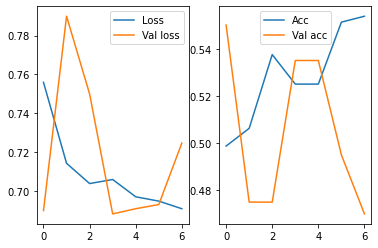

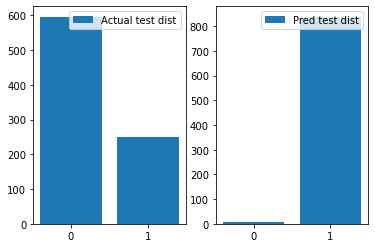

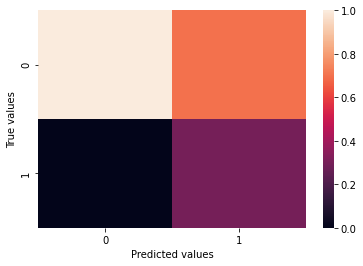

              precision    recall  f1-score   support

         0.0       1.00      0.01      0.03       596
         1.0       0.30      1.00      0.46       250

    accuracy                           0.30       846
   macro avg       0.65      0.51      0.24       846
weighted avg       0.79      0.30      0.15       846

Test accuracy: 0.305


In [23]:
historylist_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_3yr.append(history)
max_acc_3yr = -1
max_idx_3yr = -1
for i,hist in enumerate(historylist_3yr):
    if max(hist.history['val_acc']) > max_acc_3yr: 
        max_acc_3yr = max(hist.history['val_acc'])
        max_idx_3yr = i
    
print("Best val acc:",max_acc_3yr)
print("For config: ",test_params[max_idx_3yr])

In [ ]:
bs = test_params[max_idx_3yr].pop('batch_size')
model_ff_3yr = create_model(**test_params[max_idx_3yr])
test_params[max_idx_3yr].update({'batch_size': bs})

history_3yr = model_ff_3yr.fit(x_train_3yr, y_train_3yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_3yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_3yr]['batch_size'],
                                                          test_params[max_idx_3yr]['nodes1'],
                                                          test_params[max_idx_3yr]['nodes2'],
                                                          test_params[max_idx_3yr]['dropout_rate'],
                                                          test_params[max_idx_3yr]['learning_rate'],
                                                          test_params[max_idx_3yr]['optimizer'])
plot_results_nn(history_3yr,model_ff_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_3yr)


#### S&P

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop [CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop [CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 


[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.524, total=   7.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.523, total=   7.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.566, total=   7.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.515, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.526, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop [CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.529, total=   7.2s

[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.541, total=   7.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.538, total=   7.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.0s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.587, total=   6.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.599, total=   7.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.523, total=   7.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.514, total=   7.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.9s
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9248/dense_2_loss/mul_1'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9250/dense_2_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.517, total=   7.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.523, total=   6.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.3s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.518, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.455, total=   6.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.532, total=   6.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.489, total=   7.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.2s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.502, total=   7.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.526, total=   7.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.479, total=   6.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.520, total=   6.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9275/dense_5_loss/sub_2'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9274/dense_6_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.488, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   42.7s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.514, total=   7.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.498, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.447, total=   6.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.512, total=   7.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rat

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   50.7s


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=   6.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.509, total=   7.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.486, total=   7.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.498, total=   7.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, 

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9300/dense_9_loss/Log_1'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   58.8s
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_18603/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   1.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.514, total=   7.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.486, total=   7.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, ep

[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.520, total=   9.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.514, total=   9.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.500, total=   9.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.532, total=   9.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, d

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.511, total=   9.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.456, total=   9.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.509, total=   9.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.520, total=   9.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9333/dense_12_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.557, total=  10.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.502, total=  10.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.508, total=   9.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.486, total=   9.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1,

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.0min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.523, total=  14.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.520, total=  14.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.529, total=  14.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.545, total=  14.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.3min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=   9.5s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=   9.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.479, total=   9.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.512, total=  38.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dro

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.532, total=  11.7s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.575, total=  12.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.547, total=  14.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.544, total=  13.8s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9392/dense_20_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=nan, total=   1.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.559, total=  14.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.524, total=  13.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.562, total=  13.2s
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.541, total=  13.2s[CV] batch_siz

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.548, total=  11.9s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.544, total=  11.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.538, total=  12.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.497, total=  12.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, drop

[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.7min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.505, total=  12.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.514, total=  12.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.461, total=  12.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.526, total=  12.6s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9425/dense_24_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.512, total=  12.4s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.498, total=  12.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.495, total=  12.3s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=

[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  4.2min


[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.498, total=  13.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.514, total=  12.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.485, total=  12.1s
[CV] batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.511, total=  11.4s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate

[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:  4.6min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.538, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.547, total=   7.3s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.560, total=   7.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.532, total=  14.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate

[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:  5.1min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.477, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.426, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.482, total=   7.4s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.486, total=   7.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, drop

[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.4min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.495, total=   7.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.482, total=   7.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.498, total=   7.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=   7.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, 

[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:  5.9min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.556, total=   9.4s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.581, total=   9.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.523, total=   9.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.527, total=   9.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:  6.4min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.517, total=   9.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.508, total=   9.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.509, total=   9.7s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.511, total=   9.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.9min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.502, total=  10.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.486, total=   9.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.467, total=   9.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.480, total=   9.6s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rat

[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  7.8min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.554, total=  41.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.556, total=  13.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.560, total=  12.9s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.547, total=  13.5s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropo

[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:  8.5min


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.500, total=  12.2s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.511, total=  12.0s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.511, total=  11.8s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.515, total=  12.1s
[CV] batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9660/dense_56_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.486, total=  13.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.486, total=  12.9s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.569, total=  12.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.505, total=  12.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=1, dropout_rate=

[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.2min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.535, total=  13.9s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.526, total=  14.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.559, total=  10.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.538, total=  10.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, e

[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed: 10.0min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.523, total=  11.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.529, total=  11.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.523, total=  14.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.539, total=   8.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed: 10.9min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.532, total=  10.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.474, total=  14.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.473, total=  13.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.517, total=  13.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_r

[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 12.3min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.514, total=  30.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.512, total=  13.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.523, total=  20.1s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.529, total=  15.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropou

[Parallel(n_jobs=-1)]: Done 562 tasks      | elapsed: 13.7min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.495, total=  22.7s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.518, total=  26.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.515, total=  17.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.529, total=  17.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9802/dense_92_loss/Log'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.517, total=  18.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.538, total=  27.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.545, total=  29.4s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_ra

[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 15.8min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.523, total=  28.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9833/dense_101_loss/clip_by_value'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.563, total=  33.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.511, total=  40.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.541, total=  31.2s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dr

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 17.8min


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.563, total=  22.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.547, total=  22.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.523, total=  21.3s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.502, total=  28.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9870/dense_107_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   0.8s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.587, total=  24.5s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.515, total=  40.0s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.523, total=  39.6s
[CV] batch_size=8, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9893/dense_117_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   1.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.538, total=  11.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.515, total=  14.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.502, total=  13.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5,

[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 19.2min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.511, total=  11.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.502, total=  19.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.514, total=  18.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.533, total=  11.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_9933/dense_117_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   1.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.514, total=   9.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.514, total=  12.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.467, total=   9.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=

[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 20.3min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.492, total=  10.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.492, total=  14.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.476, total=  10.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.500, total=  16.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate

[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.517, total=  22.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.529, total=  23.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.584, total=  24.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.544, total=  33.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 745 tasks      | elapsed: 21.8min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.556, total=  24.2s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.518, total=  16.7s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.544, total=  18.2s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.498, total=  18.4s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_r

[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.498, total=  14.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.506, total=  16.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.556, total=  17.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.554, total=  26.9s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_ra

[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 23.7min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.511, total=  18.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.483, total=  26.4s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.527, total=  30.8s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.508, total=  30.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropo

[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.495, total=  30.0s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.547, total=  22.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.553, total=  22.3s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.530, total=  29.6s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2,

[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed: 26.2min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.565, total=  23.1s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.514, total=  30.4s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.547, total=  22.2s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.533, total=  26.5s
[CV] batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=2,

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.520, total=  13.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.569, total=  49.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.523, total=  48.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.523, total=  13.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.

[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 28.9min


[CV]  batch_size=8, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.556, total=  34.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.559, total=  11.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.538, total=  10.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.563, total=  15.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=2, dropout_rate=0.5, e

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_20236/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=nan, total=   1.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.488, total=  24.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.517, total=  30.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.502, total=  24.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10127/dense_177_loss/clip_by_value'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   2.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.523, total=   8.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.548, total=  28.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.536, total=  28.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=

[Parallel(n_jobs=-1)]: Done 909 tasks      | elapsed: 31.1min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.488, total=  24.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.505, total=  15.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.547, total=  24.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.532, total=  30.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rat

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_69_27/dropout/mul_1'

  FitFailedWarning)


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   1.8s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.535, total=  15.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.502, total=  11.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.505, total=  10.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2,

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.521, total=  54.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.568, total=  45.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed: 33.6min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.523, total=  52.3s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.483, total=  46.5s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.476, total=  54.4s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.505, total=  54.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, d

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.523, total=  26.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.541, total=  44.7s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.538, total=  21.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.559, total=  22.9s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 37.4min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.512, total=  43.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.526, total= 1.1min
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.562, total=  44.1s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.502, total=  45.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.563, total= 1.1min
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.520, total= 1.1min
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.556, total= 1.1min
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.526, total=  30.0s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate

[Parallel(n_jobs=-1)]: Done 1042 tasks      | elapsed: 42.0min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.536, total=  44.6s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.529, total=  41.2s
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.545, total= 1.4min
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.544, total= 1.4min
[CV] batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth

[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.545, total= 1.4min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.553, total= 1.4min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.590, total=  12.7s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.532, total=  16.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0

[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed: 47.1min


[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.553, total= 1.3min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.508, total= 1.5min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.514, total=  24.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.535, total=  35.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_ra

[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.524, total=  17.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.498, total=  14.5s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.560, total=  26.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.518, total=  12.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, e

[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 49.3min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.446, total=  18.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.502, total=  20.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=  19.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.514, total=  19.7s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, 

[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.511, total= 1.0min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.515, total=  26.9s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.562, total=  26.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.503, total=  19.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropou

[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 52.9min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.505, total=  40.1s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.532, total=  37.2s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.538, total=  38.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.538, total= 1.1min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth

[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.505, total=  59.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.523, total=  37.6s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.524, total=  38.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.488, total=  50.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate

[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 57.3min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.523, total=  45.8s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.483, total=  43.7s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.551, total= 1.2min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.533, total= 1.4min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout

[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.575, total=  38.4s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.523, total=  38.3s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.578, total= 1.2min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.500, total=  29.8s
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rat

[Parallel(n_jobs=-1)]: Done 1285 tasks      | elapsed: 64.3min


[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.508, total= 1.6min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.539, total= 1.3min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.529, total= 1.1min
[CV] batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=8, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.535, total= 1.5min
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=8, depth=3, dropout_rat

[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.515, total=   5.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.489, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.514, total=   6.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.485, total=   6.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout

[Parallel(n_jobs=-1)]: Done 1336 tasks      | elapsed: 65.6min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.505, total=   6.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.520, total=   6.3s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.512, total=   6.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.498, total=   6.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10593/dense_335_loss/Neg'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   0.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.511, total=   6.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.502, total=   6.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.512, total=   6.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_

[Parallel(n_jobs=-1)]: Done 1389 tasks      | elapsed: 66.4min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.539, total=   7.5s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.535, total=   7.6s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.550, total=   7.8s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.536, total=   7.7s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, dept

[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.486, total=   7.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.488, total=   7.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=   6.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=   7.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10666/dense_338_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   0.7s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.502, total=   8.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.503, total=   8.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.502, total=   8.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, d

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 67.4min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.541, total=   9.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.548, total=   8.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.556, total=   9.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.547, total=   9.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropo

[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.554, total=  10.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.483, total=  10.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.502, total=   9.4s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.491, total=   9.2s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16,

[Parallel(n_jobs=-1)]: Done 1497 tasks      | elapsed: 68.5min


[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.512, total=   9.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.514, total=   8.9s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.505, total=   9.0s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.521, total=   9.1s
[CV] batch_size=16, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10756/dense_369_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   0.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.526, total=   6.2s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.508, total=   6.5s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.485, total=   6.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_

[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 69.2min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.486, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.502, total=   6.2s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.488, total=  14.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.502, total=  13.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=1, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10809/dense_356_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   0.8s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.498, total=   5.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.514, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.500, total=   6.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_

[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed: 70.2min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.520, total=   7.8s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.524, total=   7.6s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.505, total=   7.5s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.538, total=   7.7s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10853/dense_378_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.485, total=   8.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.505, total=   8.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.492, total=   7.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.476, total=   7.7s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, d

[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.514, total=   7.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.563, total=   9.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.514, total=   9.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.538, total=   9.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1

[Parallel(n_jobs=-1)]: Done 1666 tasks      | elapsed: 71.2min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.550, total=   9.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.532, total=   9.1s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.572, total=   9.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_10903/dense_370_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.529, total=   9.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.505, total=   9.0s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.560, total=   8.4s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, 

[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.511, total=   9.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.506, total=   9.2s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.502, total=   9.3s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.489, total=   7.5s
[CV] batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=

[Parallel(n_jobs=-1)]: Done 1725 tasks      | elapsed: 72.4min


[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.477, total=  10.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.514, total=  10.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.509, total=  10.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.517, total=   9.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dro

[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.503, total=  13.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.492, total=  13.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.535, total=  13.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_21993/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=nan, total=   1.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.514, total=   9.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.523, total=  10.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.536, total=  10.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, 

[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 74.0min


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.532, total=  13.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.526, total=   9.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.511, total=   9.3s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.505, total=  14.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropou

[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.482, total=  30.7s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.556, total=  31.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.517, total=  19.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.548, total=  20.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, dept

[Parallel(n_jobs=-1)]: Done 1845 tasks      | elapsed: 76.6min


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.482, total=  30.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.526, total=  35.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.529, total=  29.9s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.520, total=  29.6s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, dep

[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.565, total=  22.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.520, total=  22.3s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.526, total=  18.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.547, total=  18.0s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2

[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed: 79.7min


[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.520, total=  18.8s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.514, total=  23.2s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.529, total=  32.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.509, total=  33.4s
[CV] batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_si

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.538, total=  10.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.578, total=   9.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.559, total=  16.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.527, total= 1.0min
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_ra

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_11183/dense_428_loss/mul'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   2.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.532, total=  12.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.511, total=  24.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.544, total=  55.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rat

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 83.0min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.506, total=  10.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.520, total=  24.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.498, total=   9.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.480, total=   9.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropo

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_11229/dense_451_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.498, total=   7.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.486, total=   7.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.502, total=  12.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_ra

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.569, total=  18.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.520, total=  20.4s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 85.0min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.529, total=  21.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.514, total=  26.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.530, total=  35.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.547, total=  34.9s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, d

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.444, total=  22.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.489, total=  13.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.502, total=  26.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.473, total=  26.4s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropo

[Parallel(n_jobs=-1)]: Done 2097 tasks      | elapsed: 88.2min


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.523, total=  22.4s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.571, total=  17.5s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.547, total=  17.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.584, total=  23.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=2

[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.575, total=  54.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.488, total=  28.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.520, total=  28.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_22736/acc/div_no_nan/ReadVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.566, total=  49.6s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.541, total=  50.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.529, total=  51.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=2, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_11374/dense_486_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.0s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.486, total=  25.2s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.477, total=  21.7s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.521, total=  24.1s
[CV] batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=2,

[Parallel(n_jobs=-1)]: Done 2162 tasks      | elapsed: 92.3min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.542, total=  15.3s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.514, total=  15.6s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.514, total=  15.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.535, total=  52.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=2, dr

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_22802/acc/Cast_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=nan, total=   3.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_225_18/dropout/Shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   3.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.529, total=  10.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=0.502, total=   9.7s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.495, total=  23.5s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_22868/acc/div_no_nan'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   2.5s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.526, total=  18.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.526, total=  17.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.512, total=  16.3s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_ra

[Parallel(n_jobs=-1)]: Done 2229 tasks      | elapsed: 95.7min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.527, total=  24.5s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.503, total=  37.9s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.486, total=  38.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.508, total=  43.0s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, 

[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.502, total=  25.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.495, total=  24.3s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.498, total=  23.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.581, total=  23.4s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, de

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_11528/dense_549_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   1.5s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.467, total=  33.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2296 tasks      | elapsed: 100.9min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.517, total=  50.7s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.535, total=  43.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.514, total=  43.8s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.530, total=  32.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, 

[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.547, total= 1.9min
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.548, total= 1.9min
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.494, total=  38.1s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.526, total= 1.9min
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth

[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.542, total=  54.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 


[Parallel(n_jobs=-1)]: Done 2365 tasks      | elapsed: 109.0min


[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.532, total=  54.6s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.506, total=  50.2s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.520, total=  58.3s
[CV] batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.502, total=  56.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dro

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.532, total=  55.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.539, total=  30.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.479, total=  53.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.486, total=  52.4s[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam, score=0.517, total=  52.8s
[CV] batc

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_23275/acc/Greater'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.508, total=   9.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.524, total=  17.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.605, total=  17.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.511, total=  19.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dr

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_594_18/Identity'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=nan, total=   3.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.517, total=  48.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.503, total=  14.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.498, total=  11.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_r

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_23330/acc/div_no_nan/ReadVariableOp_1'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   1.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.512, total=  19.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.485, total=  17.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 113.5min


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.486, total=  20.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.498, total=  17.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.514, total=  17.8s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dropout_298_16/Identity'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=nan, total=   2.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.485, total=  17.4s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.485, total=  23.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.520, total=  21.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.523, total=  20.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.542, total=  20.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.520, total= 1.4min
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.562, total=  21.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=16, dep

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_23442/acc/Mean'

  FitFailedWarning)


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   1.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.502, total=  41.9s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.520, total=  37.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.514, total=  41.2s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3

[Parallel(n_jobs=-1)]: Done 2505 tasks      | elapsed: 118.7min


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.527, total=  29.1s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.492, total=  27.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.526, total=  23.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.483, total=  46.6s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.544, total=  36.6s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.502, total= 1.8min
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.533, total= 1.9min
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.523, total=  32.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=16, dep

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.538, total= 2.0min
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.538, total= 2.2min
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.459, total=  39.5s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 127.3min


[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.511, total=  37.3s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.473, total=  36.6s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=  29.7s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.526, total=  30.0s
[CV] batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, d

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.506, total= 1.9min
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.505, total= 1.9min
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.488, total=   5.3s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.441, total=   4.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, d

[CV]  batch_size=16, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.565, total= 2.2min
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.498, total=   5.8s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.486, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.515, total=   5.8s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 2649 tasks      | elapsed: 130.3min


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=   4.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.520, total=   5.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.502, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.512, total=   6.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_11909/dense_656_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.530, total=   5.6s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.565, total=   5.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.520, total=   6.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.554, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.514, total=   6.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.542, total=   7.3s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.498, total=   8.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.502, total=   7.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, 

[Parallel(n_jobs=-1)]: Done 2722 tasks      | elapsed: 131.4min


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=   7.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=   7.7s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.512, total=   8.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.486, total=   8.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, dept

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.547, total=   7.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.524, total=   9.0s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.541, total=   8.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.511, total=   9.2s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1,

[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.468, total=   9.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.512, total=   9.1s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.502, total=   8.4s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.514, total=   8.5s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, drop

[Parallel(n_jobs=-1)]: Done 2797 tasks      | elapsed: 132.8min


[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.502, total=   8.9s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.498, total=   9.5s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.449, total=   9.3s
[CV] batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.498, total=   9.7s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12044/dense_673_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   0.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.517, total=   6.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.489, total=   4.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.542, total=   4.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.524, total=   6.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.508, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.529, total=   6.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.508, total=   6.6s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropo

[Parallel(n_jobs=-1)]: Done 2872 tasks      | elapsed: 133.7min


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.502, total=   5.4s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.488, total=   6.4s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.520, total=   6.6s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.498, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=1, dropou

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.502, total=   6.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.410, total=   4.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.498, total=   7.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.514, total=   7.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.502, total=   7.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.514, total=   5.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.512, total=   4.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.502, total=   7.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dr

[Parallel(n_jobs=-1)]: Done 2949 tasks      | elapsed: 135.1min


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.498, total=   7.7s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.553, total=   7.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.548, total=   5.0s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.538, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=

[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.511, total=  10.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.497, total=  10.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.483, total=   9.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.489, total=   9.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12220/dense_686_loss/Mean'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12222/dense_711_loss/Log'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.491, total=   5.9s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.517, total=   6.5s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_24462/acc/div_no_nan/ReadVariableOp'

  FitFailedWarning)


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=nan, total=   1.1s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.547, total=   8.3s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.480, total=   7.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.512, total=   8.8s
[CV] batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=

[Parallel(n_jobs=-1)]: Done 3026 tasks      | elapsed: 136.6min


[CV]  batch_size=32, depth=1, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.486, total=  12.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_24520/acc/Sum'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   2.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_718_18/BiasAdd'

  FitFailedWarning)
C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_718_18/Sigmoid'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   2.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam, score=nan, total=   2.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.495, total=   8.2s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.489, total=   9.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, 

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.526, total=  14.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.538, total=  14.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.523, total=  18.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.548, total=  13.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, drop

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.517, total=  13.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.551, total=   8.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.535, total=   8.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.559, total=   8.1s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropo

[Parallel(n_jobs=-1)]: Done 3105 tasks      | elapsed: 138.6min


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam, score=0.520, total=  11.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.526, total=  15.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.527, total=  22.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.532, total=  22.2s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12354/dense_711_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   1.4s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.529, total=  24.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.529, total=  19.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.533, total=  10.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12381/dense_734_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.459, total=   9.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.514, total=   8.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.486, total=  11.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropo

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.541, total=  29.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.569, total=  29.2s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 141.7min


[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.562, total=  30.5s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=0.529, total=  31.2s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.547, total=  36.6s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.524, total=  37.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, dept

[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.541, total=  19.8s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.547, total=  27.7s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.505, total=  12.3s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.486, total=  13.0s
[CV] batch_size=32, depth=2, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dro

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.521, total=   7.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.553, total=  14.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.480, total=  15.5s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=adam, score=0.502, total=  14.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=2, dropou

[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 145.1min


[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.560, total=   8.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.502, total=   8.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12500/dense_751_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=nan, total=   2.1s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.535, total=   8.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.532, total=  12.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop, score=0.521, total=   7.5s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_25054/acc/AssignAddVariableOp'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   2.1s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.502, total=   7.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.502, total=  11.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.470, total=  11.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_r

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.520, total=  21.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.535, total=  21.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.482, total=  22.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.568, total=  21.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, dept

[Parallel(n_jobs=-1)]: Done 3346 tasks      | elapsed: 147.5min


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.550, total=  11.5s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.544, total=  28.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.569, total=  13.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.526, total=  22.5s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=3

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12596/dense_761_loss/add_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   1.6s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.535, total=  19.7s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.535, total=  19.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.486, total=   8.3s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dr

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12616/dense_777_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.511, total=  20.8s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.569, total=  17.3s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.508, total=  21.0s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dro

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12627/dense_802_loss/Mean'

  FitFailedWarning)


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   1.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.535, total=  15.9s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.580, total=  19.5s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=0.511, total=  20.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=

[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop, score=0.550, total=  36.2s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.437, total=  18.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 


[Parallel(n_jobs=-1)]: Done 3429 tasks      | elapsed: 151.2min


[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.498, total=  17.3s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam, score=0.569, total=  30.4s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.523, total=  16.3s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.527, total=  15.1s
[CV] batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=2

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12692/dense_800_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/shape'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   2.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.489, total=  10.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.508, total=  34.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=2, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.520, total=  28.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout

[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.491, total=  21.6s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.508, total=  21.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.526, total=  20.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.521, total=  17.7s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_25484/acc/Identity'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   4.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_25490/acc/Cast_3'

  FitFailedWarning)
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed: 154.4min


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=nan, total=   2.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.498, total=  16.2s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.488, total=  16.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.518, total=  16.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=5, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12764/dense_860_loss/sub_2'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=rmsprop, score=nan, total=   3.0s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.523, total=  15.4s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.563, total=  16.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=50, optimizer=adam, score=0.553, total=  17.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropou

[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.488, total=  23.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.583, total=  39.8s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.527, total=  38.2s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12801/dense_869_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam, score=nan, total=   2.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.538, total=  42.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.544, total=  39.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop [CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.541, total=  38.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=50, optimizer=rmsprop 

[CV]  batch_size=32, depth=3

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12821/dense_838_loss/clip_by_value/Minimum'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   3.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.544, total=  13.2s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.527, total=  26.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.505, total=  49.2s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dro

[Parallel(n_jobs=-1)]: Done 3597 tasks      | elapsed: 159.2min


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.535, total= 1.1min
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.527, total=  21.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.529, total=  20.6s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam, score=0.506, total=  16.5s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_25726/acc/Greater'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=nan, total=   2.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.521, total= 1.1min
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.544, total= 1.1min
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam, score=0.477, total= 1.1min
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, d

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_25730/acc/Size'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=nan, total=   4.1s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.514, total= 1.2min
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=100, optimizer=adam, score=0.511, total=  19.3s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.557, total=  56.9s
[CV] batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=0.0001, nodes=500, optimizer=adam 
[CV]  batch_size=32,

[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam, score=0.545, total=   8.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=rmsprop, score=0.526, total=   8.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.529, total= 1.2min
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.533, total= 1.2min
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropo

[Parallel(n_jobs=-1)]: Done 3682 tasks      | elapsed: 165.6min


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.517, total=  20.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.485, total=  21.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.505, total= 1.2min
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.2, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam, score=0.514, total= 1.0min
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_12926/dense_893_loss/Log_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=nan, total=   1.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.479, total=   8.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=50, optimizer=adam, score=0.544, total=   8.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.548, total=  29.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropou

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'dense_888_22/Identity'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=adam, score=nan, total=   3.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=50, optimizer=adam, score=0.489, total=  11.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.482, total=  16.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=100, optimizer=rmsprop, score=0.511, total=  16.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=5, learning_rate=1e-05, nodes=250, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_r

[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.565, total=  37.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.554, total=  40.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=250, optimizer=adam, score=0.556, total=  38.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop, score=0.533, total=  13.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3

[Parallel(n_jobs=-1)]: Done 3769 tasks      | elapsed: 169.6min


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.569, total=  42.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.541, total=  40.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=100, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=rmsprop, score=0.486, total=  47.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.001, nodes=500, optimizer=adam, score=0.520, total=  38.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=0.0001, nodes=250, optimizer=rmsprop 
[CV]  batch_size=32, depth=

[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.491, total=  35.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.530, total=  40.4s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.508, total=  39.9s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.505, total=  42.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_13043/dense_919_loss/add_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=adam, score=nan, total=   2.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=250, optimizer=adam, score=0.474, total=  36.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.486, total=  42.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=10, learning_rate=1e-05, nodes=500, optimizer=rmsprop, score=0.494, total=  43.8s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth=3, drop

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'loss_13060/dense_913_loss/mul_1'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=adam, score=nan, total=   2.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.541, total=  18.6s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=100, optimizer=adam, score=0.532, total=  19.5s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=250, optimizer=rmsprop, score=0.575, total= 1.1min
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.001, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, 

[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 175.8min


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=adam, score=0.526, total=  56.4s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=0.0001, nodes=250, optimizer=rmsprop, score=0.523, total= 1.0min
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.464, total=  18.0s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=rmsprop, score=0.498, total=  17.2s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=50, optimizer=adam 
[CV]  batch_size=32, depth

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
KeyError: 'metrics_26215/acc/Size'

  FitFailedWarning)


[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=adam, score=nan, total=   2.7s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.474, total=  16.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=100, optimizer=adam, score=0.483, total=  12.4s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=rmsprop 
[CV]  batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=250, optimizer=rmsprop, score=0.524, total=  59.1s
[CV] batch_size=32, depth=3, dropout_rate=0.5, epochs=15, learning_rate=1e-05, nodes=500, optimizer=adam 
[CV]  batch_size=32, depth=3, 

[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed: 178.4min finished


Best: 0.564004 using {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'adam'}
0.526011 (0.010727) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.529005 (0.006067) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'adam'}
0.538973 (0.019175) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.529020 (0.014639) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'adam'}
0.536938 (0.044172) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 250, 'optimizer': 'rmsprop'}
nan (nan) with: {'batch_size': 8, 'depth': 1, 'dropout_rate': 0.2, 'epochs': 5, 'learning_rate': 0.001,

0.537990 (0.013072) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 250, 'optimizer': 'adam'}
0.493005 (0.006038) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 500, 'optimizer': 'rmsprop'}
0.538979 (0.014981) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.001, 'nodes': 500, 'optimizer': 'adam'}
0.529970 (0.025083) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.0001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.494995 (0.004305) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.0001, 'nodes': 50, 'optimizer': 'adam'}
0.510987 (0.026177) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.0001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.525007 (0.015532) with: {'batch_size': 8, 'depth': 3, 'dropout_rate': 0.5, 'epochs': 5, 'learn

0.530045 (0.032206) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.001, 'nodes': 500, 'optimizer': 'rmsprop'}
0.519001 (0.004958) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.001, 'nodes': 500, 'optimizer': 'adam'}
0.541964 (0.025401) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.546978 (0.016644) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 50, 'optimizer': 'adam'}
0.549966 (0.025438) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.534978 (0.015922) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epochs': 15, 'learning_rate': 0.0001, 'nodes': 100, 'optimizer': 'adam'}
0.536000 (0.008582) with: {'batch_size': 16, 'depth': 2, 'dropout_rate': 0.5, 'epoc

0.551947 (0.040158) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 250, 'optimizer': 'rmsprop'}
0.520026 (0.018759) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 250, 'optimizer': 'adam'}
0.520005 (0.006060) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 500, 'optimizer': 'rmsprop'}
0.531031 (0.022079) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.001, 'nodes': 500, 'optimizer': 'adam'}
0.507993 (0.005509) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.474064 (0.045587) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 50, 'optimizer': 'adam'}
0.517994 (0.018866) with: {'batch_size': 32, 'depth': 1, 'dropout_rate': 0.5, 'epochs

nan (nan) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.535991 (0.018286) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 100, 'optimizer': 'adam'}
0.542983 (0.014031) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 250, 'optimizer': 'rmsprop'}
0.520991 (0.016015) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 250, 'optimizer': 'adam'}
0.528022 (0.016743) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 500, 'optimizer': 'rmsprop'}
0.537990 (0.007117) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 0.0001, 'nodes': 500, 'optimizer': 'adam'}
0.495010 (0.022004) with: {'batch_size': 32, 'depth': 2, 'dropout_rate': 0.2, 'epochs': 1

0.529005 (0.004333) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 1e-05, 'nodes': 500, 'optimizer': 'rmsprop'}
0.488998 (0.001882) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 10, 'learning_rate': 1e-05, 'nodes': 500, 'optimizer': 'adam'}
0.533006 (0.007479) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 15, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'rmsprop'}
0.529023 (0.016472) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 15, 'learning_rate': 0.001, 'nodes': 50, 'optimizer': 'adam'}
0.511035 (0.025221) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 15, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'rmsprop'}
0.555981 (0.014215) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs': 15, 'learning_rate': 0.001, 'nodes': 100, 'optimizer': 'adam'}
0.534972 (0.021515) with: {'batch_size': 32, 'depth': 3, 'dropout_rate': 0.2, 'epochs':

Train on 800 samples, validate on 200 samples
Epoch 1/100000
800/800 [==============================] - 1s 1ms/sample - loss: 0.7049 - acc: 0.4712 - val_loss: 0.7033 - val_acc: 0.4700
Epoch 2/100000
800/800 [==============================] - 1s 768us/sample - loss: 0.6979 - acc: 0.5225 - val_loss: 0.6980 - val_acc: 0.5100
Epoch 3/100000
800/800 [==============================] - 1s 716us/sample - loss: 0.6837 - acc: 0.5688 - val_loss: 0.6922 - val_acc: 0.5250
Epoch 4/100000
800/800 [==============================] - 1s 732us/sample - loss: 0.6812 - acc: 0.5425 - val_loss: 0.6956 - val_acc: 0.5150
Epoch 5/100000
800/800 [==============================] - 1s 823us/sample - loss: 0.6847 - acc: 0.5462 - val_loss: 0.6929 - val_acc: 0.5100
Epoch 6/100000
800/800 [==============================] - 1s 726us/sample - loss: 0.6806 - acc: 0.5663 - val_loss: 0.6974 - val_acc: 0.5200


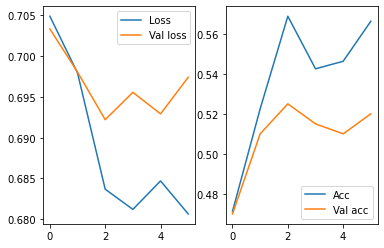

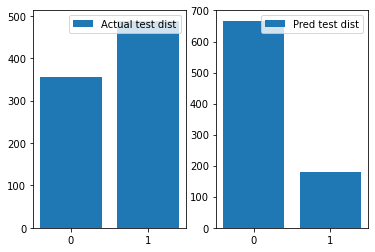

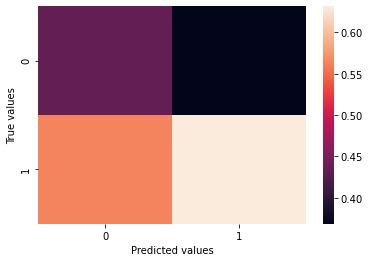

              precision    recall  f1-score   support

         0.0       0.44      0.82      0.57       357
         1.0       0.63      0.23      0.34       489

    accuracy                           0.48       846
   macro avg       0.53      0.52      0.45       846
weighted avg       0.55      0.48      0.44       846

Test accuracy: 0.478


In [24]:
historylist_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_sp.append(history)
max_acc_sp = -1
max_idx_sp = -1
for i,hist in enumerate(historylist_sp):
    if max(hist.history['val_acc']) > max_acc_sp: 
        max_acc_sp = max(hist.history['val_acc'])
        max_idx_sp = i
    
print("Best val acc:",max_acc_sp)
print("For config: ",test_params[max_idx_sp])

In [ ]:
bs = test_params[max_idx_sp].pop('batch_size')
model_ff_sp = create_model(**test_params[max_idx_sp])
test_params[max_idx_sp].update({'batch_size': bs})

history_sp = model_ff_sp.fit(x_train_sp, y_train_sp,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)],
                               validation_split=0.2)
savename_sp = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_sp]['batch_size'],
                                                          test_params[max_idx_sp]['nodes1'],
                                                          test_params[max_idx_sp]['nodes2'],
                                                          test_params[max_idx_sp]['dropout_rate'],
                                                          test_params[max_idx_sp]['learning_rate'],
                                                          test_params[max_idx_sp]['optimizer'])
plot_results_nn(history_sp,model_ff_sp,x_test_sp, y_test_sp,save=True, name=savename_sp)


### Neural Network - GloVe embeddings as embedded layer
Similar to the previous neural network, but with an embedded layer that is trained together with the weights in the feed-forward network. 

In [21]:
# Create functions for custom 'MergeEmedding'-layer which averages 
# the embeddings over all words after the embedding layer 
def merge_embeddings(x):
    # Sum the embeddings for every word slot. If this is zero, there is no word in this slot
    non_zero = K.sum(K.cast(K.not_equal(K.sum(x,axis=2),0),tf.float32))
    return K.sum(x,axis=1) / non_zero

def merge_output_shape(input_shape):
    return input_shape[0], input_shape[-1]


def create_model_emb_ff(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop',learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                        input_length=maxlen))
    model.add(Lambda(merge_embeddings, output_shape=merge_output_shape))
    if nodes1 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] batch_size=4, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  batch_size=4, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, score=0.488, total=  23.3s
[CV] batch_size=4, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.2s remaining:    0.0s


[CV]  batch_size=4, depth=1, dropout_rate=0.5, epochs=5, learning_rate=0.0001, nodes=100, score=0.474, total=  23.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   46.5s finished


Best: 0.481000 using {'batch_size': 4, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.0001, 'nodes': 100}
0.481000 (0.007000) with: {'batch_size': 4, 'depth': 1, 'dropout_rate': 0.5, 'epochs': 5, 'learning_rate': 0.0001, 'nodes': 100}
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 8s 10ms/sample - loss: 0.6947 - acc: 0.4837 - val_loss: 0.6921 - val_acc: 0.4900
Epoch 2/20
800/800 [==============================] - 8s 10ms/sample - loss: 0.6938 - acc: 0.5000 - val_loss: 0.6905 - val_acc: 0.6000
Epoch 3/20
800/800 [==============================] - 8s 10ms/sample - loss: 0.6936 - acc: 0.5150 - val_loss: 0.6904 - val_acc: 0.5850
Epoch 4/20
800/800 [==============================] - 8s 10ms/sample - loss: 0.6922 - acc: 0.5225 - val_loss: 0.6896 - val_acc: 0.5200
Epoch 5/20
800/800 [==============================] - 8s 10ms/sample - loss: 0.6918 - acc: 0.5200 - val_loss: 0.6906 - val_acc: 0.5050
Epoch 6/20
800/800 [======

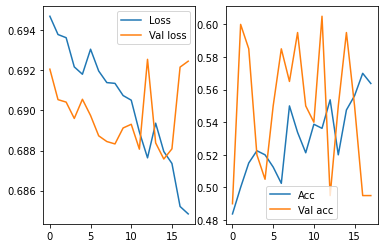

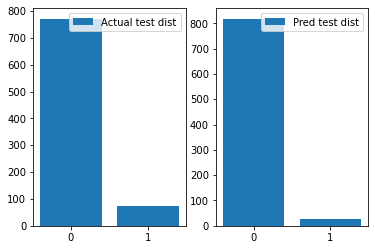

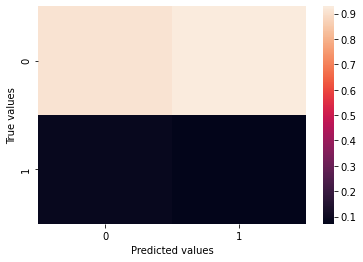

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       771
         1.0       0.07      0.03      0.04        75

    accuracy                           0.88       846
   macro avg       0.49      0.50      0.49       846
weighted avg       0.84      0.88      0.86       846

Test accuracy: 0.883


In [22]:
historylist_emb_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model_emb_ff(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_seq_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_emb_1yr.append(history)
max_acc_emb_1yr = -1
max_idx_emb_1yr = -1
for i,hist in enumerate(historylist_emb_1yr):
    if max(hist.history['val_acc']) > max_acc_emb_1yr: 
        max_acc_emb_1yr = max(hist.history['val_acc'])
        max_idx_emb_1yr = i
    
print("Best val acc:",max_acc_emb_1yr)
print("For config: ",test_params[max_idx_emb_1yr])

In [ ]:
bs = test_params[max_idx_emb_1yr].pop('batch_size')
model_emb_1yr = create_model_emb_ff(**test_params[max_idx_emb_1yr])
test_params[max_idx_emb_1yr].update({'batch_size': bs})

history_emb_1yr = model_emb_1yr.fit(x_train_seq_1yr, y_train_1yr,
                                    epochs=100000,
                                    batch_size = bs,
                                    verbose=1,
                                    callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                                    validation_split=0.2)
savename_emb_1yr = "nn_emb_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_emb_1yr]['batch_size'],
                                                              test_params[max_idx_emb_1yr]['nodes1'],
                                                              test_params[max_idx_emb_1yr]['nodes2'],
                                                              test_params[max_idx_emb_1yr]['dropout_rate'],
                                                              test_params[max_idx_emb_1yr]['learning_rate'],
                                                              test_params[max_idx_emb_1yr]['optimizer'])
plot_results_nn(history_emb_1yr,model_emb_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_emb_1yr)

#### 3 year rate

In [ ]:
historylist_emb_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model_emb_ff(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_seq_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_emb_3yr.append(history)
max_acc_emb_3yr = -1
max_idx_emb_3yr = -1
for i,hist in enumerate(historylist_emb_3yr):
    if max(hist.history['val_acc']) > max_acc_emb_3yr: 
        max_acc_emb_3yr = max(hist.history['val_acc'])
        max_idx_emb_3yr = i
    
print("Best val acc:",max_acc_emb_3yr)
print("For config: ",test_params[max_idx_emb_3yr])

In [ ]:
bs = test_params[max_idx_emb_3yr].pop('batch_size')
model_emb_3yr = create_model_emb_ff(**test_params[max_idx_emb_3yr])
test_params[max_idx_emb_3yr].update({'batch_size': bs})

history_emb_3yr = model_emb_3yr.fit(x_train_seq_3yr, y_train_3yr,
                                    epochs=100000,
                                    batch_size = bs,
                                    verbose=1,
                                    callbacks = [Earlystopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                                    validation_split=0.2)
savename_emb_3yr = "nn_emb_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_emb_3yr]['batch_size'],
                                                              test_params[max_idx_emb_3yr]['nodes1'],
                                                              test_params[max_idx_emb_3yr]['nodes2'],
                                                              test_params[max_idx_emb_3yr]['dropout_rate'],
                                                              test_params[max_idx_emb_3yr]['learning_rate'],
                                                              test_params[max_idx_emb_3yr]['optimizer'])
plot_results_nn(history_emb_3yr,model_emb_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_emb_3yr)

#### S&P

In [ ]:
historylist_emb_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model_emb_ff(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_seq_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_emb_sp.append(history)
max_acc_emb_sp = -1
max_idx_emb_sp = -1
for i,hist in enumerate(historylist_emb_sp):
    if max(hist.history['val_acc']) > max_acc_emb_sp: 
        max_acc_emb_sp = max(hist.history['val_acc'])
        max_idx_emb_sp = i
    
print("Best val acc:",max_acc_emb_sp)
print("For config: ",test_params[max_idx_emb_sp])

In [ ]:
bs = test_params[max_idx_emb_sp].pop('batch_size')
model_emb_sp = create_model_emb_ff(**test_params[max_idx_emb_sp])
test_params[max_idx_emb_sp].update({'batch_size': bs})

history_emb_sp = model_emb_sp.fit(x_train_seq_sp, y_train_sp,
                                    epochs=100000,
                                    batch_size = bs,
                                    verbose=1,
                                    callbacks = [Earlystopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                                    validation_split=0.2)
savename_emb_sp = "nn_emb_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_emb_sp]['batch_size'],
                                                              test_params[max_idx_emb_sp]['nodes1'],
                                                              test_params[max_idx_emb_sp]['nodes2'],
                                                              test_params[max_idx_emb_sp]['dropout_rate'],
                                                              test_params[max_idx_emb_sp]['learning_rate'],
                                                              test_params[max_idx_emb_sp]['optimizer'])
plot_results_nn(history_emb_sp,model_emb_sp,x_test_sp, y_test_sp,save=True, name=savename_emb_sp)

### Neural Network - GloVe embeddings and Bidirectional LSTM
The same embeddings as in the previous model, but with a bidircetional LSTM rather than a multi layer perceptron the top.

In [25]:
def create_model_lstm(nodes=128, dropout_rate=0.3, recurrent_dropout=0.3, optimizer='rmsprop',learning_rate=0.001):
    if optimizer == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                        input_length=maxlen))
    model.add(Bidirectional(LSTM(nodes, recurrent_dropout=recurrent_dropout)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [1]:
479600 / 12

39966.666666666664

#### 1 year rate

In [27]:
earlystop_lstm = EarlyStopping(monitor='val_acc',
                               patience=2,
                               restore_best_weights=True)

lstm_1yr_mod = create_model_lstm() 
lstm_1yr_hist = lstm_1yr_mod.fit(x_train_1yr_seq, y_train_1yr,
                                 epochs=10,
                                 validation_split=0.2, 
                                 verbose=1,
                                 batch_size=64,
                                 callbacks=[earlystop_lstm])

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 2327s 3s/sample - loss: 0.7242 - acc: 0.5225 - val_loss: 0.6996 - val_acc: 0.4950
Epoch 2/10
800/800 [==============================] - 2571s 3s/sample - loss: 0.6495 - acc: 0.6438 - val_loss: 0.7020 - val_acc: 0.5350
Epoch 3/10
800/800 [==============================] - 2312s 3s/sample - loss: 0.5846 - acc: 0.7613 - val_loss: 0.7125 - val_acc: 0.5250


In [ ]:
# Perform a cross-validation to find good values of hyperparameters
lstm_mod = KerasClassifier(build_fn=create_model_lstm, verbose=0)
# define the grid search parameters
batch_size = [8,32,64]
batch_size = [4]
epochs = [4,5]
epochs = [5]
nodes = [100,250]
nodes = [100]
dropout_rates = [0.3,0.5]
dropout_rates = [0.5]
learning_rates = [1e-3, 1e-3, 1e-4, 1e-5]
learning_rates = [1e-4]

optimizers = ['rmsprop','adam']
lstm_param_grid = dict(batch_size=batch_size, 
                         epochs=epochs, 
                         nodes=nodes, 
                         dropout_rate=dropout_rates, 
                       
                         learning_rate=learning_rates)
lstm_grid = GridSearchCV(estimator=lstm_mod,
                           param_grid=lstm_param_grid, 
                           n_jobs=1, 
                           cv=2, 
                           verbose=10)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    lstm_grid_result = lstm_grid.fit(x_train_1yr_seq, y_train_1yr)
# summarize results
print("Best: %f using %s" % (lstm_grid_result.best_score_, lstm_grid_result.best_params_))
means = lstm_grid_result.cv_results_['mean_test_score']
stds = lstm_grid_result.cv_results_['std_test_score']
params = lstm_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

model_1yr_lstm = create_model_lstm(nodes=nn_emb_grid_result.best_params_['nodes'],
                                    depth=nn_emb_grid_result.best_params_['depth'],
                                    dropout_rate=nn_emb_grid_result.best_params_['dropout_rate'],
                                    learning_rate=nn_emb_grid_result.best_params_['learning_rate'])

history_1yr_lstm = model_1yr_lstm.fit(x_train_1yr_seq, y_train_1yr,
                                    validation_split=0.2,
                                    epochs=20,
                                    batch_size=nn_emb_grid_result.best_params_['batch_size'],
                                    callbacks=[earlystop],
                                    verbose=1)

plot_results_nn(history_1yr_lstm,
                model_1yr_lstm,
                x_test_1yr_seq,
                y_test_1yr,
                save=True,
                name='lstm_1yr_n{}_de{}_dr{}_lr{}'.format(lstm_grid_result.best_params_['nodes'],
                                                            lstm_grid_result.best_params_['depth'],
                                                            lstm_grid_result.best_params_['dropout_rate'],
                                                            lstm_grid_result.best_params_['learning_rate']))


In [ ]:
n_lstm1 = 128
n_lstm2 = 128
n_dense = 50
dr_rate = 0.3

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                       trainable=True))
lstm_model.add(Bidirectional(LSTM(n_lstm1, recurrent_dropout=0.2)))
lstm_model.add(Dropout(dr_rate))
lstm_model.add(Dense(n_dense))
lstm_model.add(Dropout(dr_rate))
lstm_model.add(Dense(1,activation='sigmoid'))

lstm_model.compile(optimizer='rmsprop', metrics=['acc'], loss='binary_crossentropy')
lstm_model.summary()

In [ ]:
lstm_history = lstm_model.fit(x_train_pad, y_train,
                            batch_size=64,
                            validation_split=0.2,
                            epochs=10,
                            callbacks=[earlystop])
save = False

if save: 
    plot_results_nn(lstm_history, lstm_model, x_test_pad, y_test,save=save,name='lstm_l1{}_l2{}_d{}_dr{}'.format(n_lstm1,
                                                                                                          n_lstm2,
                                                                                                          n_dense,
                                                                                                          dr_rate))
else: 
    plot_results_nn(lstm_history, lstm_model, x_test_pad, y_test)

In [ ]:
n_gru1 = 20
n_gru2 = 20
n_dense = 50
dr_rate = 0.3

gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=300,
                        mask_zero=True,
                        weights=[trainable_embeddings],
                       trainable=True))
gru_model.add(Bidirectional(GRU(n_gru1, recurrent_dropout=0.2, return_sequences=True)))
gru_model.add(Dropout(dr_rate))
gru_model.add(Bidirectional(GRU(n_gru2)))
gru_model.add(Dropout(dr_rate))
gru_model.add(Dense(n_dense))
gru_model.add(Dropout(dr_rate))
gru_model.add(Dense(1,activation='sigmoid'))

gru_model.compile(optimizer='rmsprop', metrics=['acc'], loss='binary_crossentropy')
gru_model.summary()

In [ ]:
gru_history = gru_model.fit(x_train_pad, y_train,
                            batch_size=64,
                            validation_split=0.2,
                            epochs=4)
save = False

if save: 
    plot_results_nn(gru_history, gru_model, x_test_pad, y_test,save=save,name='gru_l1{}_l2{}_d{}_dr{}'.format(n_gru1,
                                                                                                          n_gru2,
                                                                                                          n_dense,
                                                                                                          dr_rate))
else: 
    plot_results_nn(gru_history, gru_model, x_test_pad, y_test)

## Results

The following results were achieved on the independent test set on the IMDB dataset. Pre-trained GloVe-embeddings were used and 

| Model |  Test Accuracy (%) | Hyperparameters |
| :----- | --------------- | --- | 
| Random Classifier | 50.3 | N/A |
| Logistic Regression | 85.2  | N/A |
| Linear Discriminant Analysis | 85.3  | N/A |
| Support Vector Machine | 84.1 | N/A |
| Random Forest | 80.9  | n_estimators=5000, max_depth=50 |
| XGBoost | __86.1__ | n_estimators=500 |
| Multi Layer Perceptron (Pre-trained) | 85.2 | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |
| Multi Layer Perceptron (Cont. training) |  | batch_size=16,depth=3,dropout_rate=0.2,nodes=250 |
| LSTM | | n_lstm1=20, n_lstm2=20, nodes=50,dropout_rate=0.3 | 

XGBoost gives the best performance on the test set when using GloVe-embeddings. The LSTM-approach takes a lot longer to train, and it is therefore harder to conduct a decent hyperparameter search. The LSTM is the only approach that takes the order of the words into account, which could potentially give a better performance if optimized well.

For comparison, the table below displays state-of-the-art models for the IMDB classification task. 

| Model |	Accuracy (%) |	Paper / Source|
|:----- | ---------- | -------------- |  
| XLNet (Yang et al., 2019) |	__96.21__ |	XLNet: Generalized Autoregressive Pretraining for Language Understanding|
| BERT_large+ITPT (Sun et al., 2019) 	|95.79 |	How to Fine-Tune BERT for Text Classification?|
| BERT_base+ITPT (Sun et al., 2019) |	95.63 |	How to Fine-Tune BERT for Text Classification?|
| ULMFiT (Howard and Ruder, 2018) |	95.4 |	Universal Language Model Fine-tuning for Text Classification|
| Block-sparse LSTM (Gray et al., 2017) |	94.99 |	GPU Kernels for Block-Sparse Weights|
| oh-LSTM (Johnson and Zhang, 2016)| 	94.1| 	Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings |
| Virtual adversarial training (Miyato et al., 2016) |	94.1 	|Adversarial Training Methods for Semi-Supervised Text Classification |
| BCN+Char+CoVe (McCann et al., 2017) |	91.8 |	Learned in Translation: Contextualized Word Vectors |

